## Step 7: Normalization of Pan-Cancer Dataset
We perform several normalization steps including total count normalization, log transformation, Scran normalization, and analytic Pearson residuals. This prepares the data for downstream feature selection and dimensionality reduction.


## 7.1 Load Filtered AnnData

We begin by loading the QC-filtered dataset that contains only high-quality cells.


In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext rpy2.ipython

# 📥 Load filtered dataset
adata = sc.read("../../data/pancancer_qc_filtered.h5ad")
print(f"✅ Loaded QC-filtered AnnData object: {adata.shape}")


✅ Loaded QC-filtered AnnData object: (56970, 30314)


## 7.2 Log1p Normalization

We normalize gene expression by total counts and then apply a log(1 + x) transformation. This step helps mitigate technical effects related to sequencing depth.


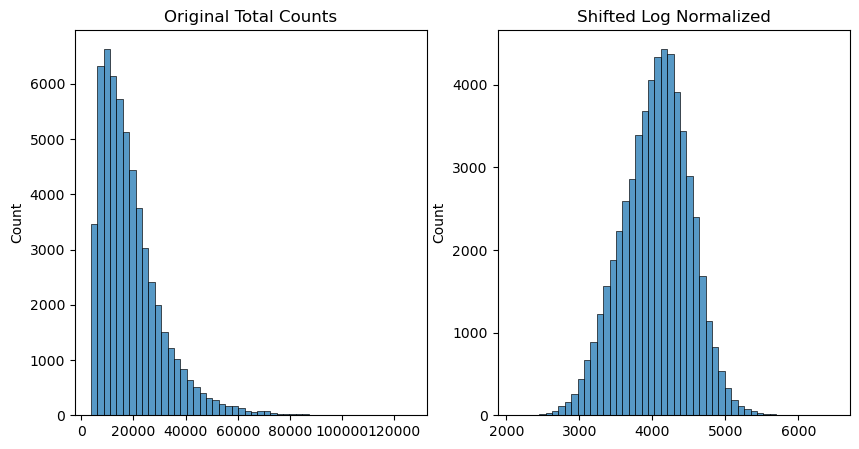

In [2]:
# 🔄 Total count normalization + log1p
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)

# 📊 Plot before and after
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["log1p_norm"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Shifted Log Normalized")
plt.show()


## 7.3 Scran Normalization: Pseudo-cluster Preparation

Scran requires cells to be grouped into clusters. We use PCA and Leiden clustering to assign pseudo-groups that represent transcriptionally similar cells.


In [3]:
# 🧪 Preprocessing for Scran
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="scran_groups")


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_386217/560780654.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="scran_groups")


## 7.4 Compute Scran Size Factors in R

We now compute size factors using the `scran` R package. These will be used to normalize UMI counts while accounting for technical effects like sequencing depth.


In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from scipy.sparse import issparse

pandas2ri.activate()

# Transpose counts matrix
data_mat = adata.X.T
if issparse(data_mat):
    data_mat = data_mat.tocsc().toarray()  # convert to dense if needed

# Send to R
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["scran_groups"]


### 🧬 R Cell: Call Scran
We use `computeSumFactors()` from the scran package to estimate size factors for each cell.


In [5]:
%%R -o size_factors
library(scran)
library(SingleCellExperiment)
library(BiocParallel)

sce <- SingleCellExperiment(list(counts = data_mat))
size_factors <- sizeFactors(computeSumFactors(
  sce,
  clusters = input_groups,
  min.mean = 0.1,
  BPPARAM = MulticoreParam()
))


R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

## 7.5 Apply Scran Normalization

We normalize each cell by its computed size factor and apply log(1 + x). We also visualize the difference in count distributions.


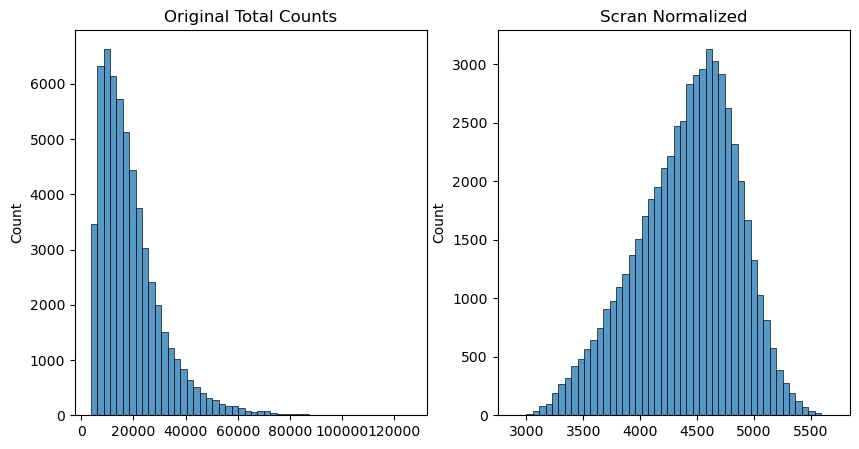

In [6]:
# Apply scran normalization
adata.obs["size_factors"] = size_factors
scran_norm = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = np.log1p(scran_norm)

# 📊 Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["scran_normalization"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Scran Normalized")
plt.show()


## 7.6 Pearson Residual Normalization

Pearson residuals offer an analytical way to stabilize variance. This is useful for downstream clustering and visualization.


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:72: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


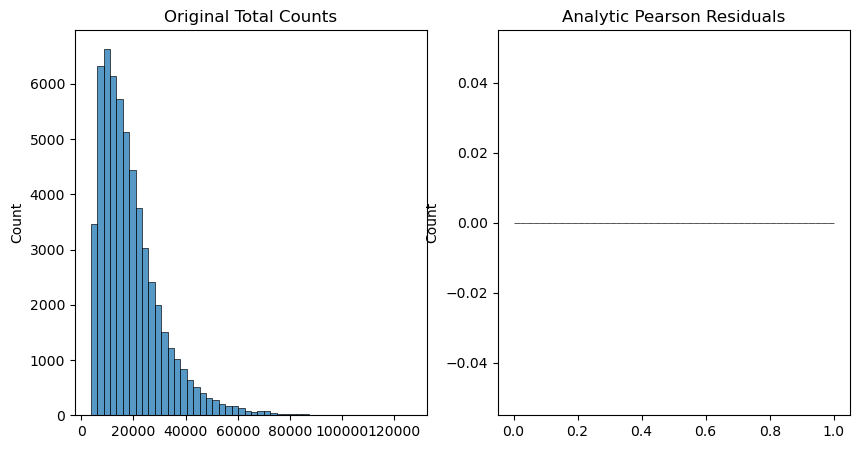

In [7]:
# 🔬 Pearson residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["pearson_residuals"] = analytic_pearson["X"]

# 📊 Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["pearson_residuals"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Analytic Pearson Residuals")
plt.show()


## 7.7 Save Normalized Dataset

We save the normalized AnnData object with all computed layers for future reuse.


In [ ]:
# 🧼 Ensure layers are in dense format if needed
from scipy.sparse import issparse
if issparse(adata.layers["scran_normalization"]):
    adata.layers["scran_normalization"] = adata.layers["scran_normalization"].tocsr()

# 💾 Save
adata.write("../../data/pancancer_normalized_all_layers.h5ad")
print("✅ Saved all normalized layers to 'pancancer_normalized_all_layers.h5ad'")


✅ Saved all normalized layers to 'pancancer_normalized_all_layers.h5ad'


: 